# Classificação multiclasse

Primeiramente devemos ler os nossos dados

In [1]:
import pandas as pd

data_path = '../data/Dry_Bean_Dataset.xlsx'
beans_data = pd.read_excel(data_path)

sample = beans_data.sample(3)
print(sample)

      Bean ID   Area  Perimeter  MajorAxisLength  MinorAxisLength  \
6546     6547  54417    915.508       371.619006       187.506834   
2808     2809  71656   1097.198       373.846717       245.155851   
5091     5092  81277   1086.749       410.108269       254.008398   

      AspectRation  Eccentricity  ConvexArea  EquivDiameter    Extent  \
6546      1.981896      0.863372       55168     263.222105  0.803749   
2808      1.524935      0.754964       73142     302.051739  0.803499   
5091      1.614546      0.785100       81916     321.690986  0.761384   

      Solidity  roundness  Compactness  ShapeFactor1  ShapeFactor2  \
6546  0.986387   0.815869     0.708312      0.006829      0.001060   
2808  0.979683   0.747984     0.807956      0.005217      0.001371   
5091  0.992199   0.864807     0.784405      0.005046      0.001178   

      ShapeFactor3  ShapeFactor4     Class  
6546      0.501706      0.994328     HOROZ  
2808      0.652793      0.995467  BARBUNYA  
5091      0.61

In [2]:
X = beans_data.iloc[:,1:-1]
y = beans_data.Class

print(X.sample(1))

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
4875  77282   1066.269        411.80318       240.602273      1.711551   

      Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness  \
4875      0.811563       77964      313.68535  0.675885  0.991252    0.85419   

      Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFactor4  
4875     0.761736      0.005329      0.001107      0.580242      0.993114  


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

## Método One versus Rest

In [4]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()

ovr = OneVsRestClassifier(model)

ovr.fit(X_train,y_train)

y_pred = ovr.predict(X_test)

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.82      0.88       331
      BOMBAY       1.00      0.98      0.99       121
        CALI       0.92      0.87      0.90       408
    DERMASON       0.92      0.83      0.87       874
       HOROZ       0.93      0.93      0.93       470
       SEKER       0.95      0.92      0.93       513
        SIRA       0.72      0.90      0.80       686

    accuracy                           0.88      3403
   macro avg       0.91      0.89      0.90      3403
weighted avg       0.89      0.88      0.88      3403

Confusion matrix:
[[273   0  22   0   2   2  32]
 [  0 118   2   0   0   1   0]
 [ 10   0 355   0  18   1  24]
 [  0   0   0 727   4  16 127]
 [  1   0   3   5 435   0  26]
 [  2   0   0   9   0 473  29]
 [  0   0   2  49  10   6 619]]


O grupo optou por fazer a própria implementação do método

Criação dos modelos

In [6]:
import numpy as np

models = []

for label in np.unique(y):
    filter = lambda r:(1 if r == label else -1)
    y_train_class = np.array([filter(row) for row in y_train])
    y_test_class = np.array([filter(row) for row in y_test])

    model = DecisionTreeClassifier()
    model.fit(X_train,y_train_class)
    models.append((model,label))

Predição

In [7]:
y_pred = np.empty(len(y_test), dtype='O')
max_prob = np.zeros(len(y_train))

for model in models:
    probability = model[0].predict_proba(X_test)[:,1]
    for i,prob in enumerate(probability):
        if max_prob[i] <= prob:
            max_prob[i] = prob
            y_pred[i] = model[1]

Resultados

In [8]:
print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.82      0.88       331
      BOMBAY       1.00      0.96      0.98       121
        CALI       0.92      0.88      0.90       408
    DERMASON       0.91      0.83      0.87       874
       HOROZ       0.92      0.92      0.92       470
       SEKER       0.96      0.92      0.94       513
        SIRA       0.72      0.90      0.80       686

    accuracy                           0.88      3403
   macro avg       0.91      0.89      0.90      3403
weighted avg       0.89      0.88      0.88      3403

Confusion matrix:
[[271   0  23   0   2   2  33]
 [  0 116   4   0   0   1   0]
 [ 11   0 357   0  22   1  17]
 [  0   0   0 723   4  12 135]
 [  1   0   4   6 431   0  28]
 [  1   0   0  10   0 474  28]
 [  1   0   1  52  10   5 617]]


Vamos criar funções para plotar as metricas de cada algoritmo

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

modelos = [
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=5)),
    ('Logistic Regression', LogisticRegression(max_iter=300)),
    ('Naive Bayes', GaussianNB())
]

# Lista para armazenar as acurácias de cada modelo
acuracias = []

# Treine e avalie cada modelo
for nome, modelo in modelos:
    ovr = OneVsRestClassifier(modelo)
    ovr.fit(X_train, y_train)
    y_pred = ovr.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Vamos plotar

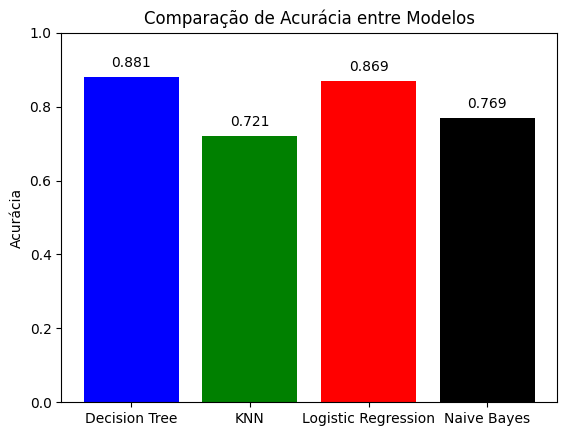

In [10]:
nomes_modelos, valores_acuracia = zip(*acuracias)
barras = plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

for barra in barras:
        altura = barra.get_height()
        plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.02, f'{altura:.3f}', ha='center', va='bottom')
plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()

## Método One versus One

### ADAG

O grupo implementou o ADAG

Variaveis

In [11]:
class_array = np.unique(y)
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)
X_test_array = np.array(X_test)
lables_data = []
models = np.empty((len(class_array),len(class_array)), dtype='O')
y_pred = np.empty(len(y_test), dtype='O')

Separacao dos dados de cada classe

In [12]:
for i,label in enumerate(class_array):
    data = np.array([row for index,row in enumerate(X_train_array) if y_train_array[index] == label])
    lables_data.append(data)

Função de criação dos modelos

In [13]:
def createModels(class_array, class_algoritmo):

    models = np.empty((len(class_array),len(class_array)), dtype='O')
    
    for i in range(len(class_array)):
        for j in range(i+1,len(class_array)):
            x_train_class = []
            for row in lables_data[i]:
                x_train_class.append(row)
            for row in lables_data[j]:
                x_train_class.append(row)


            y_train_class = [1]*len(lables_data[i]) + [0]*len(lables_data[j])
            model = ''
            if class_algoritmo.__name__ == 'LogisticRegression':
                model = class_algoritmo(max_iter=300)
            else:
                model = class_algoritmo()
            model.fit(np.array(x_train_class),np.array(y_train_class))
            models[i][j] = model
            models[j][i] = -1

    return models

Função utlizada para gerar a ordem da primeira camada do ADAG

In [14]:
def initialLevel(n_labels):
    first = 0
    second = (n_labels - 1) - n_labels%2
    level = []

    while(first < second):
        level.append(first)
        level.append(second)
        first+=1
        second-=1

    if n_labels%2 > 0:
        level.append(n_labels-1)

    return level


Função de predição das classes

In [15]:
import copy

def predict(X_test_array, class_array, models):
    y_pred = np.empty(len(X_test_array), dtype='O')

    for i,row in enumerate(X_test_array):
        levelLabels = initialLevel(len(class_array))

        while len(levelLabels) != 1:
            next_level = []

            for idx in range(0,len(levelLabels)-1 - (len(levelLabels)%2),2):
                first = min(levelLabels[idx],levelLabels[idx+1])
                second = max(levelLabels[idx],levelLabels[idx+1])

                predicao = models[first][second].predict([row])
                if predicao[0] == 1:
                    next_level.append(first)
                else:
                    next_level.append(second)

            if len(levelLabels)%2 > 0:
                next_level.append(levelLabels[len(levelLabels)-1])



            levelLabels = copy.deepcopy(next_level)

        y_pred[i] = class_array[levelLabels[0]]

    return y_pred

Resultados

In [16]:
models = createModels(class_array,LogisticRegression)
y_pred = predict(X_test_array,class_array,models)

print(classification_report(y_test, y_pred))
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.87      0.90       331
      BOMBAY       1.00      1.00      1.00       121
        CALI       0.89      0.93      0.91       408
    DERMASON       0.91      0.93      0.92       874
       HOROZ       0.92      0.94      0.93       470
       SEKER       0.95      0.95      0.95       513
        SIRA       0.87      0.84      0.86       686

    accuracy                           0.91      3403
   macro avg       0.92      0.92      0.92      3403
weighted avg       0.91      0.91      0.91      3403

Confusion matrix:
[[287   0  31   0   3   1   9]
 [  0 121   0   0   0   0   0]
 [ 14   0 380   0  11   0   3]
 [  0   0   0 809   2  10  53]
 [  4   0  11   3 444   0   8]
 [  2   0   1  10   0 488  12]
 [  3   0   2  69  22  14 576]]


Comparando a acuracia

In [17]:
algoritmos = [
    ('Decision Tree', DecisionTreeClassifier),
    ('KNN', KNeighborsClassifier),
    ('Logistic Regression', LogisticRegression),
    ('Naive Bayes', GaussianNB)
]

acuracias = []

for nome, algoritmo in algoritmos:
    models = createModels(class_array,algoritmo)
    y_pred = predict(X_test_array,class_array,models)
    acuracia = accuracy_score(y_test, y_pred)
    acuracias.append((nome, acuracia))

Plotando

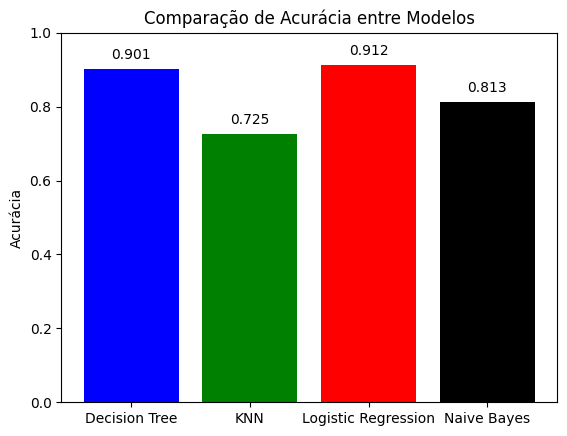

In [18]:
nomes_modelos, valores_acuracia = zip(*acuracias)
plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

barras = plt.bar(nomes_modelos, valores_acuracia, color=['blue', 'green', 'red', 'black'])  # Adicione mais cores conforme necessário

for barra in barras:
        altura = barra.get_height()
        plt.text(barra.get_x() + barra.get_width() / 2, altura + 0.02, f'{altura:.3f}', ha='center', va='bottom')

plt.ylabel('Acurácia')
plt.title('Comparação de Acurácia entre Modelos')
plt.ylim(0, 1)  # Defina o limite y de 0 a 1 para a acurácia
plt.show()
